In [2]:
from keras.models import Model

from keras import objectives
from keras.objectives import mae, categorical_crossentropy, mse

from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape

from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, UpSampling2D, ZeroPadding3D

from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU, PReLU, LeakyReLU
from keras.layers.merge import concatenate

from keras.optimizers import SGD, Adadelta, Adagrad, RMSprop,Adam
from keras.utils import np_utils, generic_utils
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [3]:
import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
from keras.optimizers import SGD, Adadelta, Adagrad, RMSprop,Adam
from keras.utils import np_utils, generic_utils
from six.moves import range
import keras
import numpy as np
import random
import pickle
import scipy.io as sio
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import h5py
import os
import tensorflow as tf
from keras import backend as K

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [6]:
# hist = np.zeros(15)
# for i in range(15):
#     hist[i] = np.sum(train_labels==i)

# ss = np.sum(hist).astype('float32')
# class_weight = dict([(i, ss/hist[i]) for i in range(15)])
# class_weight_list = [ss/hist[i] for i in range(15)]

# print(class_weight_list)

In [7]:
#class_weight_list[0] = 50
class_weight_list=[0.85, 7582.851282051282, 7375.864763752252, 2337.59072545231, 2493.8681658468026, 1092.9843336139459, 1132.4189163316103, 1058.3878317924248, 1054.8851809282232, 2350.0779656527307, 2263.0565428109853, 762.7289478586064, 777.3308411214954, 496.56358208955226, 500.8054792458511]

In [8]:
def my_to_categorical(y, nb_classes=14):
    # Y = np.zeros([y.shape[0],y.shape[1],y.shape[2],y.max()+1],dtype='uint8')
    # Y[np.nonzero(y)[0],np.nonzero(y)[1],np.nonzero(y)[2],y[np.nonzero(y)[0],np.nonzero(y)[1],np.nonzero(y)[2]]] = 1
    # Y[np.where(y == 0)[0],np.where(y == 0)[1],np.where(y == 0)[2],y[np.where(y == 0)[0],np.where(y == 0)[1],np.where(y == 0)[2]]] = 1
    for d in ['/device:GPU:0', '/device:GPU:1', '/device:GPU:2']:
        with tf.device(d):
            one_hot_y = tf.one_hot(indices = y, depth=nb_classes+1)
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
   
    Y = sess.run(one_hot_y)
    return Y

In [9]:
def dice_cost(y_true, y_predicted):
    class_weight_list_t = tf.convert_to_tensor(class_weight_list)
    num_sum = 2.0 * ((K.sum(y_true * y_predicted * class_weight_list_t) + K.epsilon()))
    den_sum =((K.sum(y_true) + K.sum(y_predicted)+ K.epsilon()))

    return 1-(num_sum/den_sum)

In [10]:
def class_weighted_pixelwise_crossentropy(target, output):
    #output = tf.clip_by_value(output, 10e-8, 1.-10e-8)
    class_weight_list_t = tf.convert_to_tensor(class_weight_list)
#     cw_loss =  -tf.reduce_sum(target * class_weight_list_t * tf.log(output))
    dice_loss = dice_cost(target,output)
    
    #return (0.3*cw_loss + 0.7*dice_loss)
    #return dice_loss
    #init_l = tf.local_variables_initializer()
    
    
    #fscore_loss = 1-fscore
    #return (tf.nn.weighted_cross_entropy_with_logits(target,output,class_weight_list_t)) + dice_loss 
    return dice_loss

In [11]:
def f1score_c(Y_pred, Y_true):
    Y_pred = Y_pred.flatten()
    Y_true = Y_true.flatten()
    return f1_score(Y_pred,Y_true)

def accuracy(Y_pre, Y_true):
    accu = ((np.sum(Y_true[np.nonzero(Y_true)]==Y_pre[np.nonzero(Y_true)],dtype='float32'))/(np.count_nonzero(Y_true)))
    zero_accu = ((np.sum(Y_true[np.where(Y_true == 0)]==Y_pre[np.where(Y_true == 0)],dtype='float32'))/(np.size(Y_true)-np.count_nonzero(Y_true)))
    return [accu,zero_accu]


smooth = 1.
def dice_coef(y_true_f, y_pred_f):
#     y_true_f = y_true.flatten()
#     y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ((2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth))*100


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [12]:
nb_classes = 14
img_w = 152
img_h = 152

In [13]:
inputs = Input((img_h, img_w, 51,1))

In [14]:
print("Model building")

zp0 = ZeroPadding3D(padding=(3,3,0))(inputs)
c3d = Conv3D(16,(7,7,51), activation='relu', kernel_initializer='glorot_uniform')(zp0)
ac3d = Activation("relu")(c3d)
bnc3d = BatchNormalization(axis=-1)(ac3d)


reshp = Reshape((img_w,img_h,16),input_shape=(img_w,img_h,1,16))(bnc3d)

nd1 = MaxPooling2D((2,2), padding="valid", data_format="channels_last")(reshp)
nd2 = MaxPooling2D((2,2), padding="valid", data_format="channels_last")(nd1)
nd3 = MaxPooling2D((2,2), padding="valid", data_format="channels_last")(nd2)

l11 = Conv2D(16,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(reshp)
al11 = Activation("relu")(l11)
bnl11 = BatchNormalization()(al11)

bnl11_reshp = concatenate([bnl11,reshp])
l12 = Conv2D(32,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(bnl11_reshp)
al12 = Activation("relu")(l12)
bnl12 = BatchNormalization()(al12)

ld1 = Dropout(0.3)(bnl12)

##################################

lm1 = MaxPooling2D((2,2), padding="valid", data_format="channels_last")(ld1)

##################################

lm1_nd1 = concatenate([lm1,nd1])
l21 = Conv2D(32,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(lm1_nd1)
al21 = Activation("relu")(l21)
bnl21 = BatchNormalization()(al21)


bnl21_lm1_nd1 = concatenate([bnl21,lm1,nd1])
l22 = Conv2D(48,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(bnl21_lm1_nd1)
al22 = Activation("relu")(l22)
bnl22 = BatchNormalization()(al22)

ld2 = Dropout(0.3)(bnl22)

##################################

lm2 = MaxPooling2D((2,2))(ld2)

##################################


lm2_nd2 = concatenate([lm2,nd2])
l31 = Conv2D(48,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(lm2_nd2)
al31 = Activation("relu")(l31)
bnl31 = BatchNormalization()(al31)


bnl31_lm2_nd2 = concatenate([bnl31,lm2,nd2])
l32 = Conv2D(64,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(bnl31_lm2_nd2)
al32 = Activation("relu")(l32)
bnl32 = BatchNormalization()(al32)

ld3 = Dropout(0.3)(bnl32)


##################################

lm3 = MaxPooling2D((2,2), padding="valid", data_format="channels_last")(ld3)

##################################

lm3_nd3 = concatenate([lm3,nd3])
l41 = Conv2D(64,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(lm3_nd3)
al41 = Activation("relu")(l41)
bnl41 = BatchNormalization()(al41)


bnl41_lm3_nd3 = concatenate([bnl41,lm3,nd3])
n1 = Conv2D(128,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(bnl41_lm3_nd3)
an1 = Activation("relu")(n1)
bnn1 = BatchNormalization()(an1)


r41 = Conv2D(64,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(bnn1)
ar41 = Activation("relu")(r41)
bnr41 = BatchNormalization()(ar41)

rd3 = Dropout(0.3)(bnr41)

######################################## DECODER ###########################################

##################################
ru3 = UpSampling2D((2,2), data_format="channels_last")(rd3)
#################################

ru3_ld3_nd2 = concatenate([ru3,ld3,nd2])
r32 = Conv2D(64,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(ru3_ld3_nd2)
ar32 = Activation("relu")(r32)
bnr32 = BatchNormalization()(ar32)


bnr32_ru3_ld3_nd2 = concatenate([bnr32,ru3,ld3,nd2])
r31 = Conv2D(48,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(bnr32_ru3_ld3_nd2)
ar31 = Activation("relu")(r31)
bnr31 = BatchNormalization()(ar31)

rd2 = Dropout(0.3)(bnr31)

##################################
ru2 = UpSampling2D((2,2), data_format="channels_last")(rd2)
#################################

ru2_ld2_nd1 = concatenate([ru2,ld2,nd1])
r22 = Conv2D(48,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(ru2_ld2_nd1)
ar22 = Activation("relu")(r22)
bnr22 = BatchNormalization()(ar22)


bnr22_ru2_ld2_nd1 = concatenate([bnr22,ru2,ld2,nd1])
r21 = Conv2D(32,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(bnr22_ru2_ld2_nd1)
ar21 = Activation("relu")(r21)
bnr21 = BatchNormalization()(ar21)

rd1 = Dropout(0.3)(bnr21)


##################################
ru1 = UpSampling2D((2,2), data_format="channels_last")(rd1)
#################################

ru1_ld1_reshp = concatenate([ru1,ld1,reshp])
r12 = Conv2D(32,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(ru1_ld1_reshp)
ar12 = Activation("relu")(r12)
bnr12 = BatchNormalization()(ar12)


bnr12_ru1_ld1_reshp = concatenate([bnr12,ru1,ld1,reshp])
r11 = Conv2D(64,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(bnr12_ru1_ld1_reshp)
ar11 = Activation("relu")(r11)
bnr11 = BatchNormalization()(ar11)

rd01 = Dropout(0.3)(bnr11)


################################
ru2_ld2_nd1 = concatenate([ru2,ld2,nd1])
ru2_2 = UpSampling2D((2,2), data_format="channels_last")(ru2_ld2_nd1)

ru3_ld3_nd2 = concatenate([ru3,ld3,nd2])
ru3_2 = UpSampling2D((4,4), data_format="channels_last")(ru3_ld3_nd2)

#################################
#'RD01','RU1','RU2_2','RU3_2','LD1','ReShp'
lyrs = concatenate([rd01,ru1,ru2_2,ru3_2,ld1,reshp])
r00 = Conv2D(200,(3,3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(lyrs)
ar00 = Activation("relu")(r00)
bnr00 = BatchNormalization()(ar00)

rd02 = Dropout(0.3)(bnr00)


lc = Conv2D(15,(1,1), activation='linear', kernel_initializer='glorot_uniform', padding='same')(rd02)
output = Activation("softmax")(lc)

Model building


In [15]:
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
adm = Adam(lr=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-08)
#ada = Adadelta()

In [16]:
print("Model compiling")
model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer=adm , loss="categorical_crossentropy", metrics=["accuracy"])
print(model.summary())

Model compiling
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 152, 152, 51, 0                                            
__________________________________________________________________________________________________
zero_padding3d_1 (ZeroPadding3D (None, 158, 158, 51, 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 152, 152, 1,  40000       zero_padding3d_1[0][0]           
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 152, 152, 1,  0           conv3d_1[0][0]                   
_____________________________________________________________________________________________

In [17]:
train_img, train_labels = preprocessing.get_data(partition=3)

11110
11110


In [18]:
train_img = np.array(train_img)

train_img = train_img.reshape(train_img.shape+(1,)).astype('float32')

In [19]:
train_labels = np.array(train_labels)

In [20]:
train_labels.shape

(3703, 152, 152)

In [21]:
train_img.shape

(3703, 152, 152, 51, 1)

In [25]:
# print("Training data shape: {0}".format(train_img.shape))
# print("Training lables shape before : {0}".format(train_labels.shape))
training_gt_category = my_to_categorical(train_labels, nb_classes)


#print("Training lables shape after : {0}".format(training_gt_category.shape))

if np.all(train_labels == np.argmax(training_gt_category,axis=-1)):
    print('Proper Conversion to categorical')

Proper Conversion to categorical


In [26]:
train_img_n.shape

(3703, 152, 152, 51, 1)

In [27]:
training_gt_category.shape

(3703, 152, 152, 15)

In [28]:
class_weight = np.zeros((3353,15))
for i in range(len(class_weight_list)):
    class_weight[:,i] = class_weight_list[i]

In [30]:
kf = KFold(n_splits=5, random_state=None, shuffle=False)

In [30]:
partition = 1

In [47]:
f1scores = []
if(partition == 1):
    for train, test in kf.split(train_img_n):
        earlystopper = EarlyStopping(patience=5, verbose=1)
        checkpointer = ModelCheckpoint('mnet_weights.h5', verbose=1, save_best_only=True)
        results = model.fit(train_img_n[train], training_gt_category[train],epochs=30, validation_split=0.1, batch_size=8,callbacks=[earlystopper, checkpointer],class_weight = class_weight)
        
        pred = model.predict(train_img_n[test],verbose=1)

        pred_t = np.argmax(pred,axis=-1).astype('uint8')

        pred_t_flat = pred_t.flatten().astype('uint8')
        test_gt_flat = np.argmax(training_gt_category[test],axis=-1).flatten().astype('uint8')

        f1score = f1_score(test_gt_flat,pred_t_flat,average='macro')
        print("f1score.....")
        print(f1score)
        f1scores.append(f1score)
        acc_sc = accuracy_score(test_gt_flat,pred_t_flat)
        print("acc_sc .....")
        print(acc_sc)

        acc,zacc = accuracy(pred_t_flat,test_gt_flat)
        print("acc.....")
        print(acc)
        print("zacc.....")
        print(zacc)




Train on 2665 samples, validate on 297 samples
Epoch 1/30
2665/2665 [==============================] - 81s 30ms/step - loss: 1.7759 - acc: 0.7285 - val_loss: 0.2477 - val_acc: 0.9888

Epoch 00001: val_loss improved from inf to 0.24767, saving model to mnet_weights.h5
Epoch 2/30
2665/2665 [==============================] - 71s 27ms/step - loss: 0.7054 - acc: 0.9612 - val_loss: 0.6329 - val_acc: 0.9616

Epoch 00002: val_loss did not improve from 0.24767
Epoch 3/30
2665/2665 [==============================] - 71s 27ms/step - loss: 0.2574 - acc: 0.9832 - val_loss: 0.1633 - val_acc: 0.9910

Epoch 00004: val_loss improved from 0.24767 to 0.16334, saving model to mnet_weights.h5
Epoch 5/30
2665/2665 [==============================] - 71s 27ms/step - loss: 0.1801 - acc: 0.9861 - val_loss: 0.0559 - val_acc: 0.9921

Epoch 00005: val_loss improved from 0.16334 to 0.05590, saving model to mnet_weights.h5
Epoch 6/30
2665/2665 [==============================] - 73s 27ms/step - loss: 0.1246 - acc: 0.

740/740 [==============================] - 7s 10ms/step
f1score.....
0.7917186727164787
acc_sc .....
0.9967800123530733
acc.....
0.7420693241684944
zacc.....
0.9994431459194097
Train on 2666 samples, validate on 297 samples
Epoch 1/30
2666/2666 [==============================] - 67s 25ms/step - loss: 0.0087 - acc: 0.9968 - val_loss: 0.0079 - val_acc: 0.9972

Epoch 00001: val_loss improved from inf to 0.00792, saving model to mnet_weights.h5
Epoch 2/30
2666/2666 [==============================] - 70s 26ms/step - loss: 0.0083 - acc: 0.9968 - val_loss: 0.0069 - val_acc: 0.9974

Epoch 00002: val_loss improved from 0.00792 to 0.00690, saving model to mnet_weights.h5
Epoch 3/30
2666/2666 [==============================] - 69s 26ms/step - loss: 0.0079 - acc: 0.9970 - val_loss: 0.0071 - val_acc: 0.9974

Epoch 00003: val_loss did not improve from 0.00690
Epoch 4/30
2666/2666 [==============================] - 69s 26ms/step - loss: 0.0078 - acc: 0.9970 - val_loss: 0.0075 - val_acc: 0.9973

Epoch

In [48]:
f1scores

[0.7040630961891993,
 0.7219133695523634,
 0.7989714639837726,
 0.7917186727164787,
 0.8050467939552025]

In [49]:
np.mean(f1scores)

0.7643426792794032

In [50]:
np.std(f1scores)

0.042518930277585444

In [ ]:
partition = 2

In [32]:
f1scores = []
if(partition != 1):
    model2 = Model(inputs=[inputs], outputs=[output])
    model2.load_weights('mnet_weights.h5')
    model2.compile(optimizer=adm , loss="categorical_crossentropy", metrics=["accuracy"])
    
    for train, test in kf.split(train_img_n):
        earlystopper = EarlyStopping(patience=5, verbose=1)
        checkpointer = ModelCheckpoint('mnet_weights.h5', verbose=1, save_best_only=True)
        results = model2.fit(train_img_n[train], training_gt_category[train],epochs=30, validation_split=0.1, batch_size=8,callbacks=[earlystopper, checkpointer],class_weight = class_weight)
        
        pred = model2.predict(train_img_n[test],verbose=1)

        pred_t = np.argmax(pred,axis=-1).astype('uint8')

        pred_t_flat = pred_t.flatten().astype('uint8')
        test_gt_flat = np.argmax(training_gt_category[test],axis=-1).flatten().astype('uint8')

        f1score = f1_score(test_gt_flat,pred_t_flat,average='macro')
        print("f1score.....")
        print(f1score)
        f1scores.append(f1score)
        acc_sc = accuracy_score(test_gt_flat,pred_t_flat)
        print("acc_sc .....")
        print(acc_sc)

        acc,zacc = accuracy(pred_t_flat,test_gt_flat)
        print("acc.....")
        print(acc)
        print("zacc.....")
        print(zacc)




Train on 2665 samples, validate on 297 samples
Epoch 1/30
2665/2665 [==============================] - 86s 32ms/step - loss: 0.0077 - acc: 0.9973 - val_loss: 0.0062 - val_acc: 0.9975

Epoch 00001: val_loss improved from inf to 0.00624, saving model to mnet_weights.h5
Epoch 2/30
2665/2665 [==============================] - 72s 27ms/step - loss: 0.0065 - acc: 0.9976 - val_loss: 0.0057 - val_acc: 0.9978

Epoch 00002: val_loss improved from 0.00624 to 0.00571, saving model to mnet_weights.h5
Epoch 3/30
2665/2665 [==============================] - 72s 27ms/step - loss: 0.0060 - acc: 0.9978 - val_loss: 0.0077 - val_acc: 0.9971

Epoch 00003: val_loss did not improve from 0.00571
Epoch 4/30
2665/2665 [==============================] - 72s 27ms/step - loss: 0.0057 - acc: 0.9979 - val_loss: 0.0059 - val_acc: 0.9977

Epoch 00004: val_loss did not improve from 0.00571
Epoch 5/30
2665/2665 [==============================] - 73s 27ms/step - loss: 0.0054 - acc: 0.9980 - val_loss: 0.0057 - val_acc: 0.

2665/2665 [==============================] - 72s 27ms/step - loss: 0.0035 - acc: 0.9986 - val_loss: 0.0045 - val_acc: 0.9982

Epoch 00004: val_loss improved from 0.00479 to 0.00447, saving model to mnet_weights.h5
Epoch 5/30
2665/2665 [==============================] - 73s 27ms/step - loss: 0.0034 - acc: 0.9986 - val_loss: 0.0051 - val_acc: 0.9981

Epoch 00005: val_loss did not improve from 0.00447
Epoch 6/30
2665/2665 [==============================] - 72s 27ms/step - loss: 0.0034 - acc: 0.9987 - val_loss: 0.0047 - val_acc: 0.9981

Epoch 00006: val_loss did not improve from 0.00447
Epoch 7/30
2665/2665 [==============================] - 72s 27ms/step - loss: 0.0033 - acc: 0.9987 - val_loss: 0.0050 - val_acc: 0.9981

Epoch 00007: val_loss did not improve from 0.00447
Epoch 8/30
2665/2665 [==============================] - 72s 27ms/step - loss: 0.0033 - acc: 0.9987 - val_loss: 0.0049 - val_acc: 0.9981

Epoch 00008: val_loss did not improve from 0.00447
Epoch 9/30
2665/2665 [============

In [33]:
np.mean(f1scores)

0.8900305124487675

In [34]:
np.std(f1scores)

0.023961330678614435

In [32]:
partition = 3

In [34]:
f1scores = []
train_img_n1 = train_img_n[0:3000]
training_gt_category1 = training_gt_category[0:3000]
if(partition != 1):
    model2 = Model(inputs=[inputs], outputs=[output])
    model2.load_weights('mnet_weights.h5')
    model2.compile(optimizer=adm , loss="categorical_crossentropy", metrics=["accuracy"])
    
    for train, test in kf.split(train_img_n1):
        earlystopper = EarlyStopping(patience=5, verbose=1)
        checkpointer = ModelCheckpoint('mnet_weights.h5', verbose=1, save_best_only=True)
        results = model2.fit(train_img_n1[train], training_gt_category1[train],epochs=30, validation_split=0.1, batch_size=8,callbacks=[earlystopper, checkpointer],class_weight = class_weight)
        
        pred = model2.predict(train_img_n1[test],verbose=1)

        pred_t = np.argmax(pred,axis=-1).astype('uint8')

        pred_t_flat = pred_t.flatten().astype('uint8')
        test_gt_flat = np.argmax(training_gt_category1[test],axis=-1).flatten().astype('uint8')

        f1score = f1_score(test_gt_flat,pred_t_flat,average='macro')
        print("f1score.....")
        print(f1score)
        f1scores.append(f1score)
        acc_sc = accuracy_score(test_gt_flat,pred_t_flat)
        print("acc_sc .....")
        print(acc_sc)

        acc,zacc = accuracy(pred_t_flat,test_gt_flat)
        print("acc.....")
        print(acc)
        print("zacc.....")
        print(zacc)




Train on 2160 samples, validate on 240 samples
Epoch 1/30
2160/2160 [==============================] - 64s 30ms/step - loss: 0.0037 - acc: 0.9985 - val_loss: 0.0040 - val_acc: 0.9983

Epoch 00001: val_loss improved from inf to 0.00404, saving model to mnet_weights.h5
Epoch 2/30
2160/2160 [==============================] - 56s 26ms/step - loss: 0.0034 - acc: 0.9986 - val_loss: 0.0037 - val_acc: 0.9984

Epoch 00002: val_loss improved from 0.00404 to 0.00373, saving model to mnet_weights.h5
Epoch 3/30
2160/2160 [==============================] - 57s 26ms/step - loss: 0.0033 - acc: 0.9987 - val_loss: 0.0040 - val_acc: 0.9984

Epoch 00003: val_loss did not improve from 0.00373
Epoch 4/30
2160/2160 [==============================] - 57s 26ms/step - loss: 0.0032 - acc: 0.9987 - val_loss: 0.0035 - val_acc: 0.9985

Epoch 00004: val_loss improved from 0.00373 to 0.00352, saving model to mnet_weights.h5
Epoch 5/30
2160/2160 [==============================] - 57s 26ms/step - loss: 0.0032 - acc: 0.

2160/2160 [==============================] - 57s 26ms/step - loss: 0.0028 - acc: 0.9989 - val_loss: 0.0043 - val_acc: 0.9984

Epoch 00009: val_loss did not improve from 0.00361
Epoch 10/30
2160/2160 [==============================] - 57s 26ms/step - loss: 0.0028 - acc: 0.9989 - val_loss: 0.0037 - val_acc: 0.9985

Epoch 00010: val_loss did not improve from 0.00361
Epoch 11/30
2160/2160 [==============================] - 56s 26ms/step - loss: 0.0028 - acc: 0.9989 - val_loss: 0.0038 - val_acc: 0.9985

Epoch 00011: val_loss did not improve from 0.00361
Epoch 00011: early stopping
600/600 [==============================] - 5s 9ms/step
f1score.....
0.9288708594206911
acc_sc .....
0.99904706255771
acc.....
0.9483948551709714
zacc.....
0.9995410283906828
Train on 2160 samples, validate on 240 samples
Epoch 1/30
2160/2160 [==============================] - 55s 25ms/step - loss: 0.0028 - acc: 0.9988 - val_loss: 0.0028 - val_acc: 0.9988

Epoch 00001: val_loss improved from inf to 0.00277, saving 

In [35]:
f1scores

[0.8874774952011099,
 0.9083678705656822,
 0.9207173162060531,
 0.9288708594206911,
 0.909237054478821]

In [36]:
np.mean(f1scores)

0.9109341191744713

In [37]:
np.std(f1scores)

0.013979388137898764

In [38]:
train_img_n2 = train_img_n[3000:-1]
training_gt_category2 = training_gt_category[3000:-1]

pred = model2.predict(train_img_n2,verbose=1)

pred_t = np.argmax(pred,axis=-1).astype('uint8')

pred_t_flat = pred_t.flatten().astype('uint8')
test_gt_flat = np.argmax(training_gt_category2,axis=-1).flatten().astype('uint8')

f1score = f1_score(test_gt_flat,pred_t_flat,average='macro')
print("f1score.....")
print(f1score)
f1scores.append(f1score)
acc_sc = accuracy_score(test_gt_flat,pred_t_flat)
print("acc_sc .....")
print(acc_sc)

acc,zacc = accuracy(pred_t_flat,test_gt_flat)
print("acc.....")
print(acc)
print("zacc.....")
print(zacc)

702/702 [==============================] - 8s 11ms/step


/home/prathyuakundi/miniconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


f1score.....
0.8454961065113736
acc_sc .....
0.9989437701738602
acc.....
0.9219173007323815
zacc.....
0.9996161989779735


[]

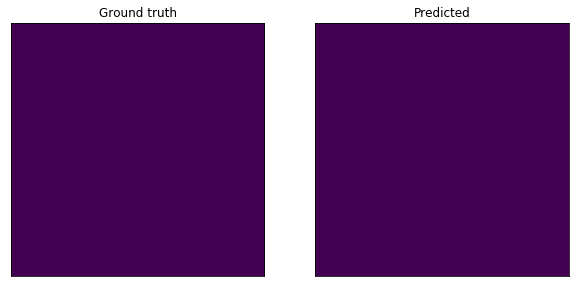

In [39]:
f,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(np.argmax(training_gt_category2[700],axis=-1))
ax[1].imshow(pred_t[700])
ax[0].set_title('Ground truth')
ax[1].set_title('Predicted')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])

[]

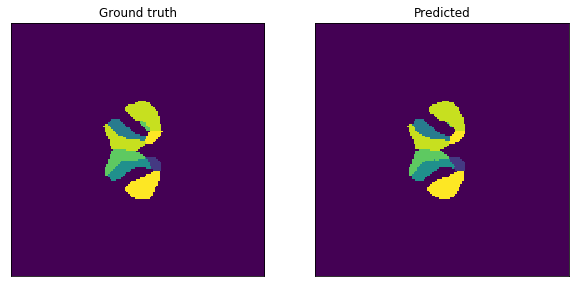

In [43]:
f,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(np.argmax(training_gt_category2[250],axis=-1))
ax[1].imshow(pred_t[250])
ax[0].set_title('Ground truth')
ax[1].set_title('Predicted')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])

[]

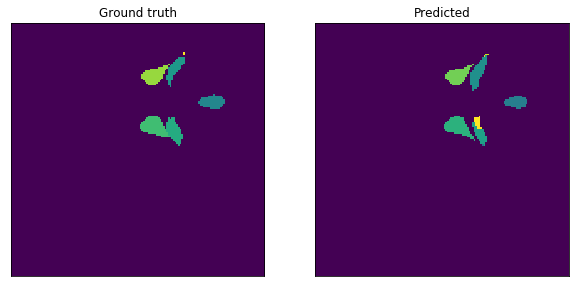

In [72]:
f,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(np.argmax(training_gt_category2[520],axis=-1))
ax[1].imshow(pred_t[520])
ax[0].set_title('Ground truth')
ax[1].set_title('Predicted')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])

[]

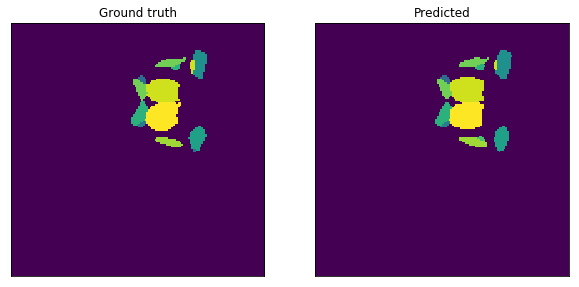

In [74]:
f,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(np.argmax(training_gt_category2[540],axis=-1))
ax[1].imshow(pred_t[540])
ax[0].set_title('Ground truth')
ax[1].set_title('Predicted')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])

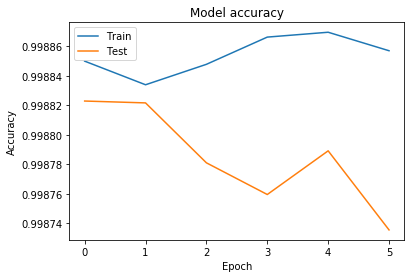

In [44]:
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

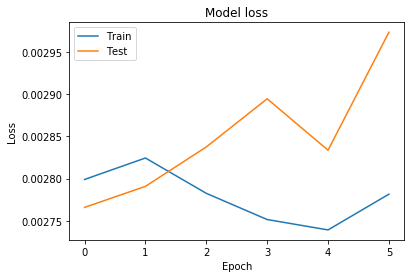

In [45]:
# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()